In [7]:
import cooler
import numpy as np
from cooltools import numutils
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import os

mpl.rcParams['font.size'] = 10
saveFigs = True 
if saveFigs == True:
    figure_path = '../figs/figure1s/count_rows/'
    os.makedirs(figure_path, exist_ok=True)
    # to save inkscape-friendly svgs
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none'}
    mpl.rcParams.update(new_rc_params)

In [8]:
# load cooler at 50kb resolution from the mcool
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
resolution = 25000
hic_cooler = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))

In [9]:
hmm_track = pd.read_csv('../annotations/GM12878_hg38_25kb.tsv', sep='\t')

if (hmm_track['end'].values[0]-hmm_track['start'].values[0]) !=  resolution: 
    raise ValueError('resolution mismatch, check files')

hmm_track.head()

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,...,binary,HMM2,HMM3,HMM3P,HMM4,HMM5,HMM6,HMM7,HMM8,HMM9
0,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,25000,50000,NaN,0.001826,0.029127,NaN,0.430960,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,50000,75000,NaN,0.019703,0.095678,NaN,0.351400,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,75000,100000,NaN,0.004713,0.046797,NaN,0.402080,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,100000,125000,NaN,0.019023,0.094014,NaN,0.371200,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
def chrom_tracks(hmm_track, hic_cooler, chrom):
    chrom_track = hmm_track[hmm_track.chrom==chrom]
    chrom_mat = numutils.adaptive_coarsegrain(hic_cooler.matrix(balance=True).fetch(chrom),
                             hic_cooler.matrix(balance=False).fetch(chrom),
                             cutoff=3, max_levels=8)
    
    return chrom_track, chrom_mat

In [243]:
chrom = 'chr20'
chrom_track, chrom_mat = chrom_tracks(hmm_track, hic_cooler, chrom)

In [244]:
mask = ~chrom_track.E1.isna().values
OE_mat, _, _, _ = numutils.observed_over_expected(chrom_mat, mask)

In [246]:
def distance(a, b):
    d = (a-b)**2
    if len(d.shape)>1:
        return d.mean(axis=1)
    
    return d.mean()

In [284]:
def plot_rows(chrom_track, OE_mat):
    fig = plt.figure(figsize=(15, 10))
    
    mask = ~chrom_track.E1.isna().values
    chrom =  chrom_track.iloc[0].chrom
    res = chrom_track.iloc[0].end - chrom_track.iloc[0].start

    for i in range(5):
        ax = plt.subplot(5, 1, i+1)
        displayed_mat = OE_mat[chrom_track.HMM3P==i ].copy()

    #     print(displayed_mat.shape)

        distances = distance(displayed_mat[:, mask], displayed_mat[0, mask])
        order = np.argsort(distances)
        im = ax.imshow(np.log2(displayed_mat[order]), 
                        cmap='bwr', aspect='auto', vmin=-2.5, vmax=2.5)
        ax.axis('off')
        

    ax.axis('on')
    ax.set_frame_on(False)
    ax.get_yaxis().set_visible(False)
    xticklabels = ((ax.xaxis.get_ticklocs()*res)).astype(int)
    ax.xaxis.set_ticklabels(xticklabels)
    
    cbar_ax = fig.add_axes([1.05, 0.2, 0.025, 0.3])
    cbar = fig.colorbar(im, cax=cbar_ax, shrink = .7, label='Observed/Expected contacts')
    plt.close(fig)        
    
    return fig

In [285]:
fig = plot_rows(chrom_track, OE_mat)

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


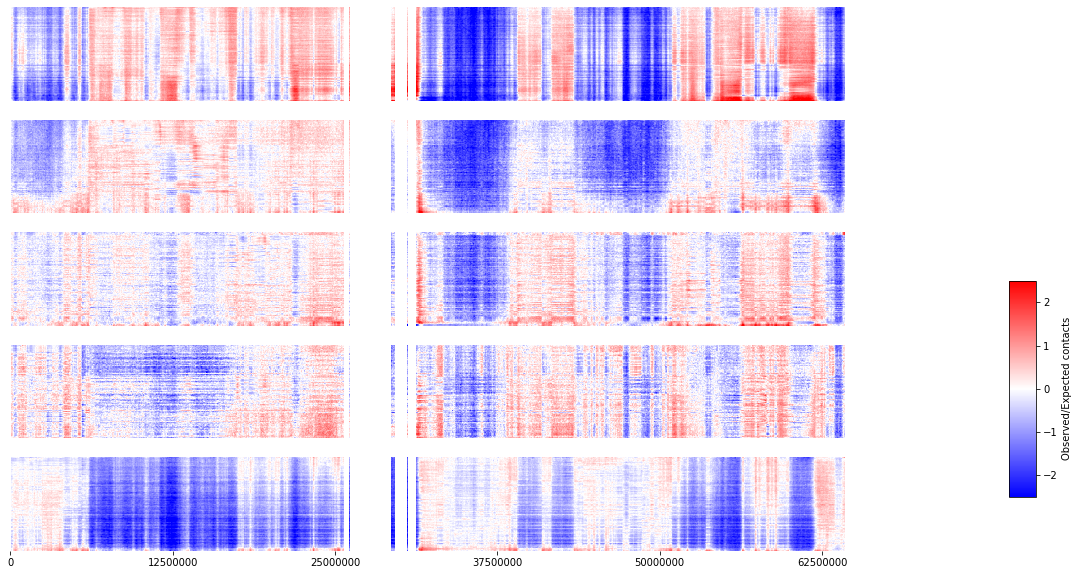

In [286]:
fig

In [287]:
def rows_multichroms(hmm_track, hic_cooler, chroms:list):
    for chrom in chroms:
        chrom_track, chrom_mat = chrom_tracks(hmm_track, hic_cooler, chrom)
        mask = ~chrom_track.E1.isna().values
        OE_mat, _, _, _ = numutils.observed_over_expected(chrom_mat, mask)
        
        fig = plot_rows(chrom_track, OE_mat)
        fig.savefig(figure_path+'intrachromsomal_patterns_'+chrom+'.svg', bbox_inches='tight')
        print("Done with: ", chrom)

In [288]:
chroms = hmm_track.chrom.unique()

In [289]:
chroms[:]

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [290]:
rows_multichroms(hmm_track, hic_cooler, chroms)

/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr1


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr2


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr3


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr4


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr5


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr6


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr7


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr8


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr9


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr10


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr11


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr12


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr13


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr14


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr15


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr16


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr17


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr18


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr19


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr20


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr21


/pollard/home/lchumpitaz/gitclones/cooltools/cooltools/lib/numutils.py:1337: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


Done with:  chr22
